In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import numpy as np
import tensorflow as tf

2024-07-22 05:59:02.729828: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-22 05:59:02.734827: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-22 05:59:02.749224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 05:59:02.763861: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 05:59:02.768136: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 05:59:02.780523: I tensorflow/core/platform/cpu_feature_gu

In [2]:
import warnings
import pandas as pd

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [3]:
def read_stock_csv(stock: str, filename: str = "") -> pd.DataFrame:
    """
    Loads the stock-price data from a csv file obtained from yahoo finance
    Retains only the date, which is set as the index, and the closing price
    """
    if not filename:
        filename = f"./data/{stock}.csv"
    df = pd.read_csv(filename)[["Date", "Close"]]
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)
    df.rename(columns={"Close": stock}, inplace=True)
    return df

In [4]:
df_sp500_3_years = read_stock_csv(
    stock="SPX", filename="../../submissions/Capstone/data/SPX_3_years.csv"
)[::-1]
df_sp500_3_years["SPX"] = df_sp500_3_years["SPX"].str.replace(",", "").apply(float)
df_sp500_3_years

,SPX
Date,
2021-07-12,4384.63
2021-07-13,4369.21
2021-07-14,4374.30
2021-07-15,4360.03
2021-07-16,4327.16
...,...
2024-07-08,5572.85
2024-07-09,5576.98
2024-07-10,5633.91


In [5]:
import matplotlib.pyplot as plt

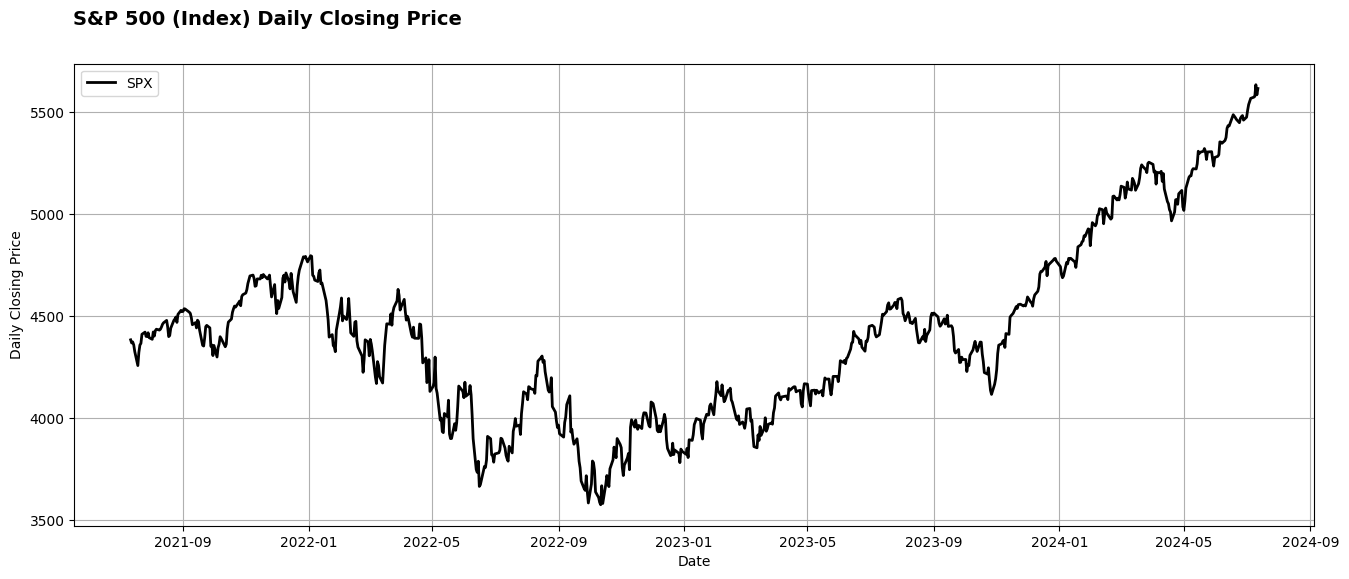

In [6]:
plt.figure(figsize=(16, 6))
column = "SPX"
plt.plot(
    df_sp500_3_years[column],
    lw=2,
    color="black",
    label=column,
)
plt.grid(True)
plt.legend()
plt.xlabel("Date")
plt.ylabel("Daily Closing Price")
plt.suptitle(
    "S&P 500 (Index) Daily Closing Price",
    fontsize=14,
    fontweight="bold",
    x=0.124,
    y=0.97,
    ha="left",
)
plt.show()

In [7]:
import numpy as np

In [8]:
def build_window(data, h, f):
    dataX, dataY = [], []
    for i in range(len(data) - h - f):
        dataX.append(data[i : (i + h)])
        dataY.append(data[(i + h) : (i + h + f)])
    dataX = np.array(dataX)
    dataY = np.array(dataY)
    return dataX, dataY

In [19]:
n_days_train, n_days_forecast = 5, 1

In [20]:
dataX, dataY = build_window(
    df_sp500_3_years["SPX"].values, h=n_days_train, f=n_days_forecast
)
[
    dataX.shape,
    dataY.shape,
]

[(750, 5), (750, 1)]

In [21]:
# np.random.seed(42)
# np.random.shuffle(dataX)
# dataX.shape

In [22]:
n_train = int(0.8 * dataY.shape[0])
trainX, trainY = dataX[:n_train, :], dataY[:n_train, :]
testX, testY = dataX[n_train:, :], dataY[n_train:, :]
[
    trainX.shape,
    trainY.shape,
    testX.shape,
    testY.shape,
]

[(600, 5), (600, 1), (150, 5), (150, 1)]

In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
def insert_singleton(X):
    return np.reshape(X, (X.shape[0], 1, X.shape[1]))

In [25]:
ss = StandardScaler().fit(trainX)
trainX_ss = insert_singleton(ss.transform(trainX))
testX_ss = insert_singleton(ss.transform(testX))
[
    trainX_ss.shape,
    testX_ss.shape,
]

[(600, 1, 5), (150, 1, 5)]

In [26]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential

In [27]:
tf.random.set_seed(42)
model = Sequential(
    [
        LSTM(32, input_shape=(1, n_days_train)),
        Dense(n_days_forecast),
    ]
)

model.compile(loss="mse", metrics=["mse"])
history = model.fit(
    trainX_ss,
    trainY,
    epochs=1000,
    batch_size=32,
    verbose=False,
    validation_data=(testX_ss, testY),
)

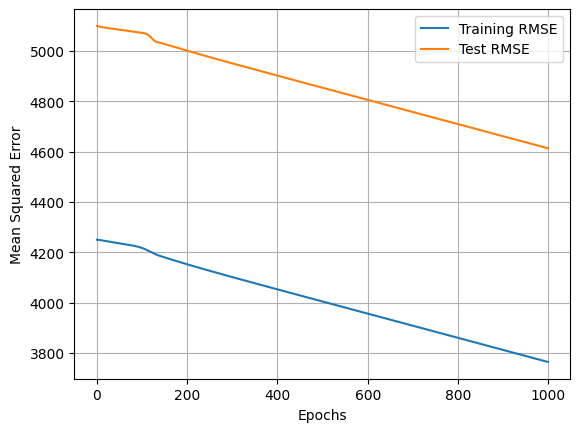

In [28]:
plt.plot(np.sqrt(history.history["mse"]), label="Training RMSE")
plt.plot(np.sqrt(history.history["val_mse"]), label="Test RMSE")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)